In [1]:
from transformer_lens import HookedTransformer
import torch
import circuitsvis as cv
import einops
from IPython.display import display
import numpy as np
from pprint import pprint
from datasets import load_dataset
import random
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from scipy.stats import hypergeom
import os
from matplotlib.patches import Patch
from utils import *    
import re

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2025-02-27 21:48:47.872567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740692927.894957  843435 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740692927.901749  843435 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print('Got device:', device)

Got device: cuda


In [3]:
model = HookedTransformer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B")
model = model.to(device)
model.cfg.n_ctx = 2048

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B into HookedTransformer
Moving model to device:  cuda


In [4]:
print(f"📏 Model context length: {model.cfg.n_ctx}")
print(f"🧠 Model layers: {model.cfg.n_layers}")
print(f"🔤 Vocabulary size: {model.cfg.d_vocab}")
print(f"📊 Hidden dimension: {model.cfg.d_model}")
print(f"🧩 Attention heads: {model.cfg.n_heads}")
print(f"🏷️ Model name: {model.cfg.model_name}")

📏 Model context length: 2048
🧠 Model layers: 28
🔤 Vocabulary size: 151936
📊 Hidden dimension: 1536
🧩 Attention heads: 12
🏷️ Model name: DeepSeek-R1-Distill-Qwen-1.5B


In [7]:
# analysis = run_analysis("math_cot_results_t=0.6_mnt=1500_tp=0.92.json")
# analysis = run_analysis("math_cot_results_t=0.7_mnt=1800_tp=0.92.json")
analysis = run_analysis("math_cot_results_t=0.8_mnt=3600_tp=0.92.json")

Analyzing 419 CoT solutions...

CHAIN-OF-THOUGHT ANALYSIS REPORT

Total problems analyzed: 419

1. CORRECTNESS
Correct answers: 216 (51.55%)

2. THINK TAGS
Solutions with </think> close tags: 311 (74.22%)

3. TOKEN LIMITS
Problems that ran out of tokens: 133 (31.74%)

4. BACKTRACKING
Solutions with backtracking: 199 (47.49%)
Sample of problems with backtracking:
     Level: Level 2, Type: Algebra, Phrases: wait, let me double-check
     Level: Level 3, Type: Algebra, Phrases: i made a mistake, let me think again
     Level: Level 4, Type: Number Theory, Phrases: i made a mistake, wait, let me double-check
     Level: Level 3, Type: Counting & Probability, Phrases: wait, let me double-check
     Level: Level 3, Type: Intermediate Algebra, Phrases: i made a mistake
     Level: Level 3, Type: Number Theory, Phrases: i made a mistake, that's not right, wait, that's not, wait, let me double-check
     Level: Level 3, Type: Prealgebra, Phrases: wait, let me double-check
     Level: Level 1, 

In [11]:
create_balanced_backtracking_dataset(
    json_file_paths=[
        "math_cot_results_t=0.6_mnt=1500_tp=0.92.json", 
        "math_cot_results_t=0.7_mnt=1800_tp=0.92.json", 
        "math_cot_results_t=0.8_mnt=3600_tp=0.92.json", 
    ],
    output_path="backtracking_dataset_n=10.json",
    n=10,
    seed=42
)

Loading data from math_cot_results_t=0.6_mnt=1500_tp=0.92.json...
Loading data from math_cot_results_t=0.7_mnt=1800_tp=0.92.json...
Loading data from math_cot_results_t=0.8_mnt=3600_tp=0.92.json...
Loaded 2225 total problems from all files
Found 1176 completed problems
Found 111 problems with backtracking that were solved correctly
Found 1016 problems without backtracking
Saved balanced dataset with 10 samples to backtracking_dataset_n=10.json


{'total_samples': 10,
 'backtracking_samples': 5,
 'no_backtracking_samples': 5,
 'unique_backtracking_ids': 5,
 'unique_no_backtracking_ids': 5,
 'original_backtracking_correct_count': 111,
 'original_no_backtracking_count': 1016,
 'total_problems_processed': 2225}

In [5]:
def identify_backtracking_neurons(model, json_file_path, min_sample_size=100, top_k=1000):
    """
    Identify neurons that activate during backtracking events by processing entire CoT solutions
    and tracking activations at specific backtracking points.
    
    Args:
        model: The HookedTransformer model
        json_file_path: Path to the JSON file with CoT results
        device: The device to run inference on
        top_k: Number of top neurons to identify
        
    Returns:
        Dictionary with neuron analysis results
    """    
    # Load the results
    with open(json_file_path, 'r') as f:
        results = json.load(f)
    
    # Initialize storage for activations
    backtracking_activations = []  # Will store (layer, position, activations)
    non_backtracking_activations = []  # Will store (layer, position, activations)
    
    # Process a subset of examples for efficiency
    sample_size = min(min_sample_size, len(results))
    sampled_results = random.sample(results, sample_size)
    
    print(f"Processing {sample_size} examples to identify backtracking neurons...")
    
    for result in tqdm(sampled_results, desc="Processing examples"):
        generated_cot = result.get("generated_cot", "")
        if not generated_cot: continue
        
        tokens = model.to_tokens(generated_cot.lower())
        str_tokens = model.to_str_tokens(generated_cot.lower())
        _, cache = model.run_with_cache(tokens)
        
        # Find positions of backtracking phrases in the token sequence
        backtracking_positions = []
        for phrase in backtracking_phrases:
            phrase_tokens = model.to_str_tokens(phrase.lower())
            
            # Look for this phrase in the token sequence
            for i in range(len(str_tokens) - len(phrase_tokens) + 1):
                match = True
                for j in range(len(phrase_tokens)):
                    if i+j >= len(str_tokens) or str_tokens[i+j].strip().lower() != phrase_tokens[j].strip().lower():
                        match = False
                        break
                
                if match:
                    backtracking_positions.append((i, i + len(phrase_tokens)))
        
        # If no backtracking phrases found, sample random positions as non-backtracking
        if not backtracking_positions:
            # Sample random positions (avoiding the beginning and end)
            if len(tokens[0]) > 20:
                num_samples = min(5, len(tokens[0]) - 10)
                for _ in range(num_samples):
                    pos = random.randint(5, len(tokens[0]) - 5)
                    # Extract activations for this position from all layers
                    for layer in range(model.cfg.n_layers):
                        layer_activations = cache["post", layer][0, pos].detach().cpu().numpy()
                        non_backtracking_activations.append((layer, layer_activations))
        else:
            # For each backtracking position, extract activations
            for start_pos, end_pos in backtracking_positions:
                # Get the position where backtracking starts
                trigger_pos = start_pos
                
                # Extract activations at the trigger position from all layers
                for layer in range(model.cfg.n_layers):
                    layer_activations = cache["post", layer][0, trigger_pos].detach().cpu().numpy()
                    backtracking_activations.append((layer, layer_activations))
                
                # Also sample non-backtracking positions from the same solution
                # (avoiding positions close to backtracking phrases)
                safe_positions = []
                for pos in range(5, len(tokens[0]) - 5):
                    # Check if this position is far from any backtracking phrase
                    is_safe = True
                    for bt_start, bt_end in backtracking_positions:
                        if pos >= bt_start - 10 and pos <= bt_end + 10:
                            is_safe = False
                            break
                    
                    if is_safe:
                        safe_positions.append(pos)
                
                # Sample from safe positions
                if safe_positions:
                    num_samples = min(len(backtracking_positions), len(safe_positions))
                    for pos in random.sample(safe_positions, num_samples):
                        # Extract activations for this position from all layers
                        for layer in range(model.cfg.n_layers):
                            layer_activations = cache["post", layer][0, pos].detach().cpu().numpy()
                            non_backtracking_activations.append((layer, layer_activations))

    print(f"Found {len(backtracking_activations)} backtracking activations and {len(non_backtracking_activations)} non-backtracking activations")
    
    # Analyze activations to find neurons that correlate with backtracking
    neuron_scores = {}
    
    # For each layer, analyze neuron activations
    for layer in tqdm(range(model.cfg.n_layers), desc="Analyzing layers"):
        layer_backtracking = np.vstack([act for l, act in backtracking_activations if l == layer])
        layer_non_backtracking = np.vstack([act for l, act in non_backtracking_activations if l == layer])
        
        if len(layer_backtracking) == 0 or len(layer_non_backtracking) == 0: continue
        
        # For each neuron, calculate its activation difference
        neuron_scores[layer] = []
        
        for neuron_idx in range(layer_backtracking.shape[1]):
            # Extract this neuron's activations
            bt_activations = layer_backtracking[:, neuron_idx]
            non_bt_activations = layer_non_backtracking[:, neuron_idx]
            
            # Calculate mean activation for backtracking vs non-backtracking
            mean_backtracking = np.mean(bt_activations)
            mean_non_backtracking = np.mean(non_bt_activations)
            
            # Calculate effect size (Cohen's d)
            pooled_std = np.sqrt((np.var(bt_activations) + np.var(non_bt_activations)) / 2)
            effect_size = (mean_backtracking - mean_non_backtracking) / (pooled_std + 1e-10)
            
            # Create dataset for AUC calculation
            X = np.concatenate([bt_activations, non_bt_activations])
            y = np.concatenate([np.ones(len(bt_activations)), np.zeros(len(non_bt_activations))])
            
            # Calculate AUC for this neuron
            try: auc = roc_auc_score(y, X)
            except: auc = 0.5  # Default if calculation fails
            
            neuron_scores[layer].append({
                'neuron': neuron_idx,
                'mean_diff': mean_backtracking - mean_non_backtracking,
                'effect_size': effect_size,
                'auc': auc
            })
        
        # Sort neurons by effect size
        neuron_scores[layer] = sorted(neuron_scores[layer], key=lambda x: abs(x['effect_size']), reverse=True)
    
    # Identify top neurons across all layers
    all_neurons = []
    for layer, neurons in neuron_scores.items():
        for n in neurons[:top_k]:
            all_neurons.append({'layer': layer, 'neuron': n['neuron'], 'effect_size': n['effect_size'], 'auc': n['auc']})
    
    # Sort by absolute effect size
    all_neurons = sorted(all_neurons, key=lambda x: abs(x['effect_size']), reverse=True)
    
    return {'top_neurons': all_neurons[:top_k], 'layer_scores': neuron_scores}

In [6]:
neuron_analysis = identify_backtracking_neurons(
    model=model,
    json_file_path="toy_dataset_n=20.json",
    top_k=1000
)

Processing 20 examples to identify backtracking neurons...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Processing examples: 100%|██████████| 20/20 [09:42<00:00, 29.11s/it]


Found 476 backtracking activations and 2380 non-backtracking activations


Analyzing layers: 100%|██████████| 28/28 [01:45<00:00,  3.75s/it]


In [7]:
# Print top neurons
print("Top 100 neurons associated with backtracking:")
for i, neuron in enumerate(neuron_analysis['top_neurons'][:100]):
    print(f"{i+1}. Layer {neuron['layer']}, Neuron {neuron['neuron']}: Effect size = {neuron['effect_size']:.4f}, AUC = {neuron['auc']:.4f}")

Top 100 neurons associated with backtracking:
1. Layer 21, Neuron 5933: Effect size = -3.2379, AUC = 0.0131
2. Layer 13, Neuron 6017: Effect size = 3.0971, AUC = 0.9952
3. Layer 17, Neuron 1027: Effect size = 2.9477, AUC = 0.9765
4. Layer 17, Neuron 602: Effect size = 2.8915, AUC = 0.9993
5. Layer 1, Neuron 8765: Effect size = 2.8042, AUC = 0.9737
6. Layer 2, Neuron 6055: Effect size = 2.7996, AUC = 0.9799
7. Layer 2, Neuron 760: Effect size = -2.6890, AUC = 0.0291
8. Layer 5, Neuron 1025: Effect size = -2.6257, AUC = 0.0194
9. Layer 21, Neuron 1917: Effect size = -2.5983, AUC = 0.0270
10. Layer 17, Neuron 1356: Effect size = 2.5921, AUC = 0.9509
11. Layer 10, Neuron 535: Effect size = -2.5565, AUC = 0.0325
12. Layer 5, Neuron 8452: Effect size = 2.5550, AUC = 0.9772
13. Layer 2, Neuron 3418: Effect size = -2.5232, AUC = 0.0360
14. Layer 6, Neuron 6439: Effect size = 2.5144, AUC = 0.9675
15. Layer 16, Neuron 2774: Effect size = 2.5109, AUC = 0.9723
16. Layer 2, Neuron 7233: Effect size

In [8]:
def validate_neurons_on_new_dataset(model, original_top_neurons, new_json_file_path, top_k=100):
    """
    Validate neurons by running the same analysis on a different dataset and comparing results.
    
    Args:
        model: The HookedTransformer model
        original_top_neurons: List of top neurons from the first analysis
        new_json_file_path: Path to a different JSON file with CoT results
        top_k: Number of top neurons to identify
        
    Returns:
        Dictionary with validation results
    """
    # Run the same analysis on the new dataset
    new_analysis = identify_backtracking_neurons(
        model=model,
        json_file_path=new_json_file_path,
        top_k=top_k
    )
    
    # Extract the top neurons from both analyses
    original_neurons = [(n['layer'], n['neuron']) for n in original_top_neurons[:top_k]]
    new_neurons = [(n['layer'], n['neuron']) for n in new_analysis['top_neurons'][:top_k]]
    
    # Find overlap between the two sets
    overlap = set(original_neurons).intersection(set(new_neurons))
    
    # Calculate overlap statistics
    overlap_count = len(overlap)
    overlap_percentage = (overlap_count / top_k) * 100
    
    # Create a mapping of neuron to rank in each analysis
    original_ranks = {(n['layer'], n['neuron']): i for i, n in enumerate(original_top_neurons[:top_k])}
    new_ranks = {(n['layer'], n['neuron']): i for i, n in enumerate(new_analysis['top_neurons'][:top_k])}
    
    # For overlapping neurons, get their ranks in both analyses
    overlap_details = []
    for layer, neuron in overlap:
        overlap_details.append({
            'layer': layer,
            'neuron': neuron,
            'original_rank': original_ranks[(layer, neuron)],
            'new_rank': new_ranks[(layer, neuron)],
            'original_effect_size': next(n['effect_size'] for n in original_top_neurons if n['layer'] == layer and n['neuron'] == neuron),
            'new_effect_size': next(n['effect_size'] for n in new_analysis['top_neurons'] if n['layer'] == layer and n['neuron'] == neuron)
        })
    
    # Sort by average rank
    overlap_details.sort(key=lambda x: (x['original_rank'] + x['new_rank'])/2)
    
    return {
        'original_neurons': original_neurons,
        'new_neurons': new_neurons,
        'overlap': list(overlap),
        'overlap_count': overlap_count,
        'overlap_percentage': overlap_percentage,
        'overlap_details': overlap_details,
        'new_analysis': new_analysis
    }

def print_validation_comparison(validation_results):
    """
    Print a comparison of the two analyses.
    
    Args:
        validation_results: Dictionary with validation results
    """
    print("\n" + "="*50)
    print("NEURON VALIDATION ACROSS DATASETS")
    print("="*50)
    
    print(f"\nOverlap: {validation_results['overlap_count']} neurons ({validation_results['overlap_percentage']:.1f}%)")
    
    print("\nTop overlapping neurons:")
    for i, neuron in enumerate(validation_results['overlap_details'][:10]):
        print(f"{i+1}. Layer {neuron['layer']}, Neuron {neuron['neuron']}:")
        print(f"   Original rank: {neuron['original_rank']+1}, Effect size: {neuron['original_effect_size']:.4f}")
        print(f"   New rank: {neuron['new_rank']+1}, Effect size: {neuron['new_effect_size']:.4f}")
    
    print("\nStatistical significance:")
    
    # Calculate p-value for this overlap using hypergeometric distribution
    # Parameters for hypergeometric test
    M = model.cfg.n_layers * model.cfg.d_model  # Total number of neurons
    n = len(validation_results['original_neurons'])  # Number of neurons in first set
    N = len(validation_results['new_neurons'])  # Number of neurons in second set
    k = validation_results['overlap_count']  # Number of overlapping neurons
    
    # Calculate p-value (probability of this much overlap or more by chance)
    p_value = 1 - hypergeom.cdf(k-1, M, n, N)
    
    print(f"p-value for overlap: {p_value:.10f}")
    if p_value < 0.05:
        print("The overlap is statistically significant (p < 0.05)")
    else:
        print("The overlap is not statistically significant (p >= 0.05)")
    
    print("\n" + "="*50)

In [9]:
validation_results = validate_neurons_on_new_dataset(
    model=model,
    original_top_neurons=neuron_analysis['top_neurons'],
    new_json_file_path="toy_dataset_n=10.json",
    top_k=100
)
print_validation_comparison(validation_results)

Processing 10 examples to identify backtracking neurons...


Processing examples: 100%|██████████| 10/10 [15:35<00:00, 93.52s/it] 


Found 280 backtracking activations and 1428 non-backtracking activations


Analyzing layers: 100%|██████████| 28/28 [01:41<00:00,  3.63s/it]


NEURON VALIDATION ACROSS DATASETS

Overlap: 19 neurons (19.0%)

Top overlapping neurons:
1. Layer 17, Neuron 1027:
   Original rank: 3, Effect size: 2.9477
   New rank: 14, Effect size: 3.4864
2. Layer 13, Neuron 6017:
   Original rank: 2, Effect size: 3.0971
   New rank: 19, Effect size: 3.3204
3. Layer 19, Neuron 6667:
   Original rank: 17, Effect size: 2.4714
   New rank: 8, Effect size: 3.6646
4. Layer 1, Neuron 813:
   Original rank: 18, Effect size: 2.4065
   New rank: 13, Effect size: 3.5103
5. Layer 4, Neuron 4889:
   Original rank: 21, Effect size: -2.3970
   New rank: 11, Effect size: -3.6167
6. Layer 17, Neuron 1356:
   Original rank: 10, Effect size: 2.5921
   New rank: 23, Effect size: 3.2437
7. Layer 5, Neuron 8452:
   Original rank: 12, Effect size: 2.5550
   New rank: 35, Effect size: 3.0518
8. Layer 4, Neuron 5357:
   Original rank: 29, Effect size: 2.3527
   New rank: 25, Effect size: 3.2006
9. Layer 10, Neuron 535:
   Original rank: 11, Effect size: -2.5565
   New r

In [36]:
def visualize_neuron_activations(model, neuron_info_list, examples):
    """
    Improved visualization of neuron activations with better readability.
    
    Args:
        model: The HookedTransformer model
        neuron_info_list: List of dictionaries with neuron information (layer, neuron)
        examples: List of text examples to analyze
        
    Returns:
        List of matplotlib figures with visualizations
    """
    all_figs = []
    
    for example in examples:
        # Identify backtracking phrases
        bt_instances = identify_backtracking(example)
        bt_phrases = [phrase for phrase, _ in bt_instances] if isinstance(bt_instances[0], tuple) else bt_instances
        
        # Get tokens
        tokens = model.to_tokens(example)
        str_tokens = model.to_str_tokens(example)
        
        # Find positions of backtracking phrases
        bt_positions = []
        for phrase in bt_phrases:
            phrase_tokens = model.to_str_tokens(phrase)
            
            # Look for this phrase in the token sequence
            for i in range(len(str_tokens) - len(phrase_tokens) + 1):
                match = True
                for j in range(len(phrase_tokens)):
                    if str_tokens[i+j].strip().lower() != phrase_tokens[j].strip().lower():
                        match = False
                        break
                
                if match:
                    bt_positions.extend(range(i, i + len(phrase_tokens)))
        
        # Run with cache once for this example
        _, cache = model.run_with_cache(tokens)
        
        # Now process each neuron using the same cache
        for neuron_info in neuron_info_list:
            layer = neuron_info['layer']
            neuron = neuron_info['neuron']
            
            # Get activations for this layer and neuron from the cache
            layer_activations = cache["post", layer][0, :, neuron].detach().cpu().numpy()
            
            # Create visualization for this neuron
            fig, ax = plt.subplots(figsize=(15, 4))
            
            # Plot activations
            bars = ax.bar(range(len(layer_activations)), layer_activations)
            
            # Color backtracking phrases
            for j, bar in enumerate(bars):
                if j in bt_positions:
                    bar.set_color('red')
            
            # IMPROVEMENT 1: Only show a subset of token labels
            # Show every nth token label to avoid overcrowding
            n = max(1, len(str_tokens) // 30)  # Show at most ~30 labels
            
            # Set x-ticks at every position but only label some
            ax.set_xticks(range(len(str_tokens)))
            sparse_labels = [''] * len(str_tokens)
            for j in range(0, len(str_tokens), n):
                sparse_labels[j] = str_tokens[j]
            
            # IMPROVEMENT 2: Always show backtracking tokens
            for j in bt_positions:
                sparse_labels[j] = str_tokens[j]
            
            # IMPROVEMENT 3: Always show high activation tokens
            threshold = np.mean(layer_activations) + np.std(layer_activations)
            for j, act in enumerate(layer_activations):
                if act > threshold and j % n != 0 and j not in bt_positions:
                    sparse_labels[j] = str_tokens[j]
            
            ax.set_xticklabels(sparse_labels, rotation=45, ha='right')
            
            # Highlight important tokens
            for j in range(len(str_tokens)):
                if sparse_labels[j]:  # Only for tokens that have labels
                    if j in bt_positions:
                        ax.get_xticklabels()[j].set_color('red')
                        ax.get_xticklabels()[j].set_weight('bold')
                    elif layer_activations[j] > threshold:
                        ax.get_xticklabels()[j].set_color('blue')
                        ax.get_xticklabels()[j].set_weight('bold')
            
            # Add a legend
            legend_elements = [
                Patch(facecolor='red', label='Backtracking phrase'),
                Patch(facecolor='blue', label='High activation (non-backtracking)')
            ]
            ax.legend(handles=legend_elements, loc='upper right')
            
            # IMPROVEMENT 4: Add vertical lines to separate logical sections
            # Add vertical lines every 10 tokens for visual guidance
            for j in range(10, len(str_tokens), 10):
                ax.axvline(x=j, color='gray', linestyle='--', alpha=0.3)
            
            # IMPROVEMENT 5: Add a mini-map view of the full sequence
            # Create a small subplot for the overview
            ax_overview = fig.add_axes([0.15, 0.85, 0.7, 0.1])
            ax_overview.bar(range(len(layer_activations)), layer_activations, color='gray', alpha=0.5)
            for j in bt_positions:
                ax_overview.axvspan(j-0.5, j+0.5, color='red', alpha=0.3)
            ax_overview.set_xticks([])
            ax_overview.set_yticks([])
            ax_overview.set_title("Full sequence overview")
            
            ax.set_title(f"Neuron {neuron} in Layer {layer}")
            ax.set_ylabel("Activation")
            
            plt.tight_layout()
            all_figs.append(fig)
    
    return all_figs

/var/folders/nx/mj3k1jbj1d342wsxms_z7y7c0000gn/T/ipykernel_67282/1970480960.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


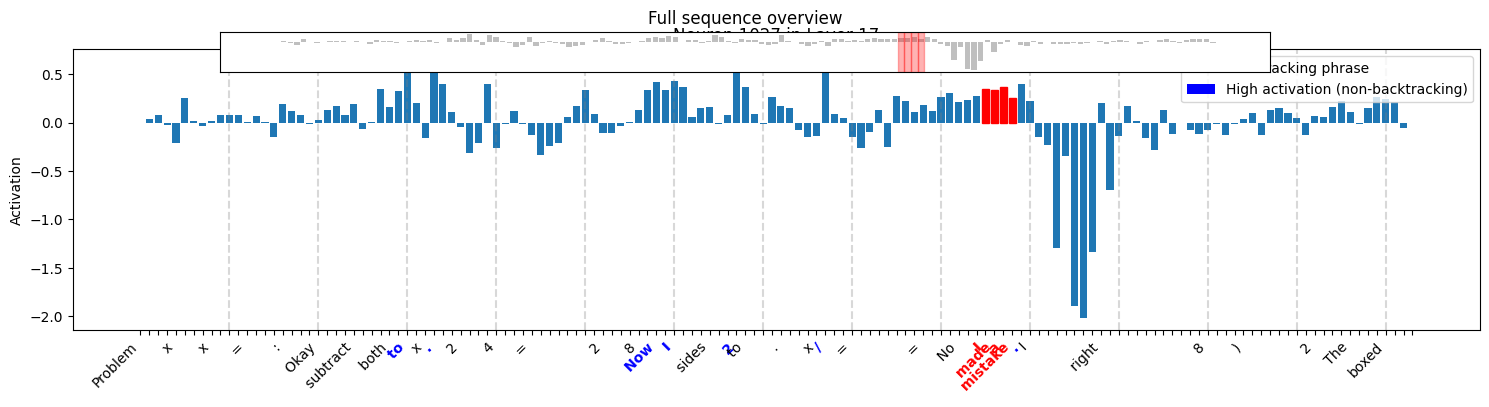

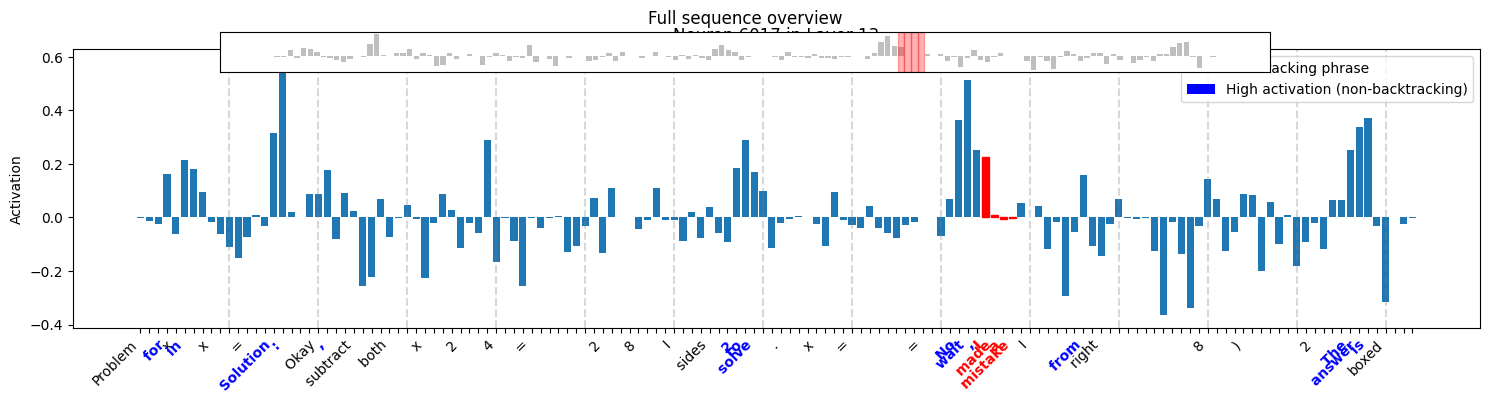

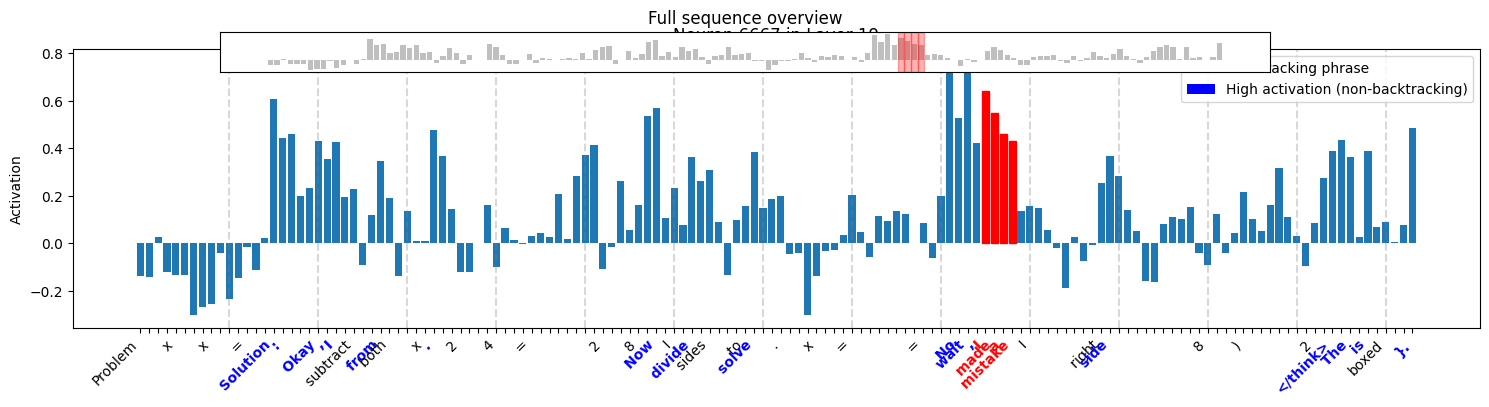

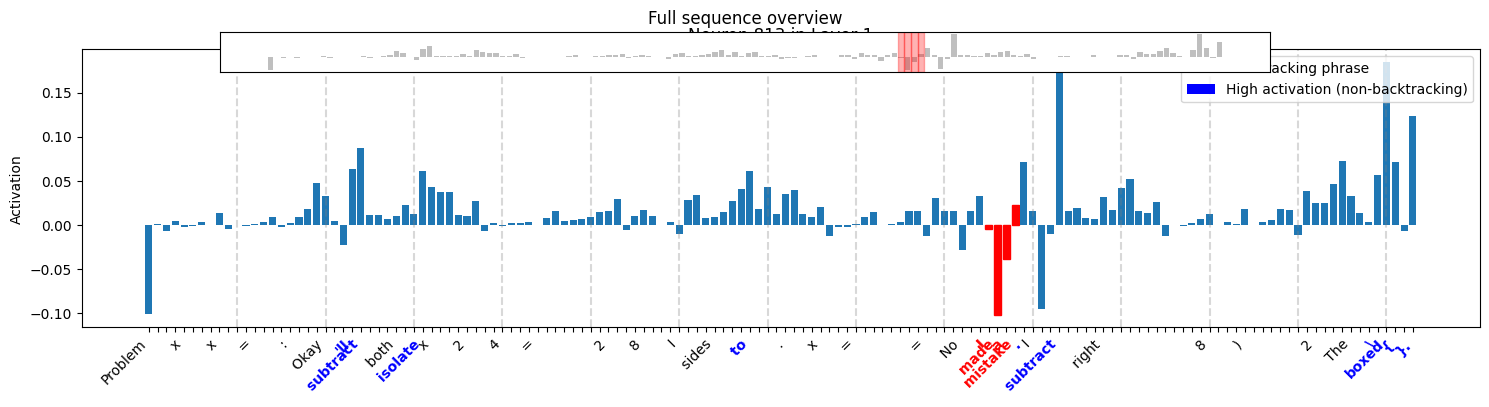

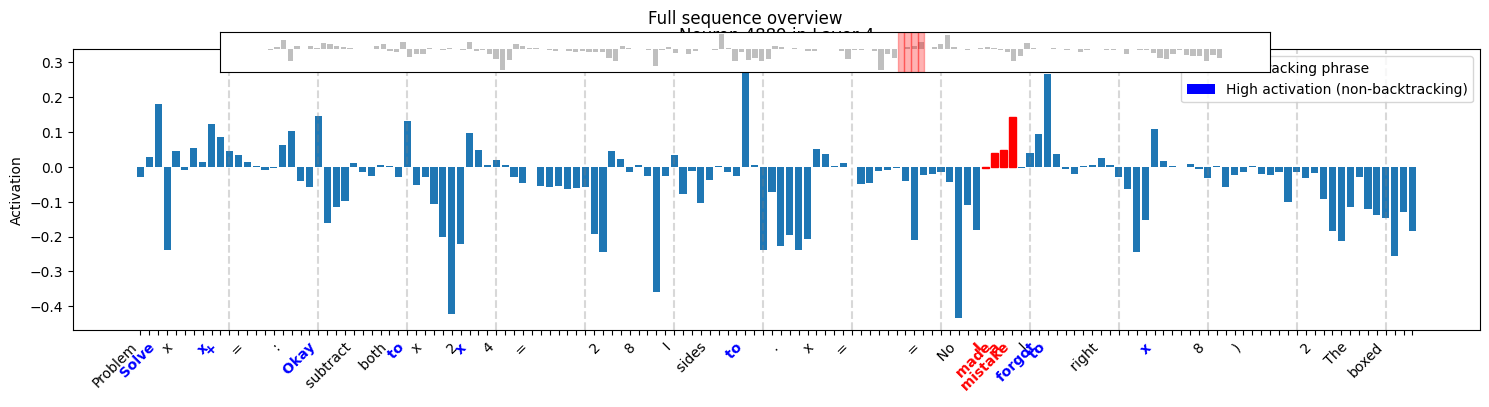

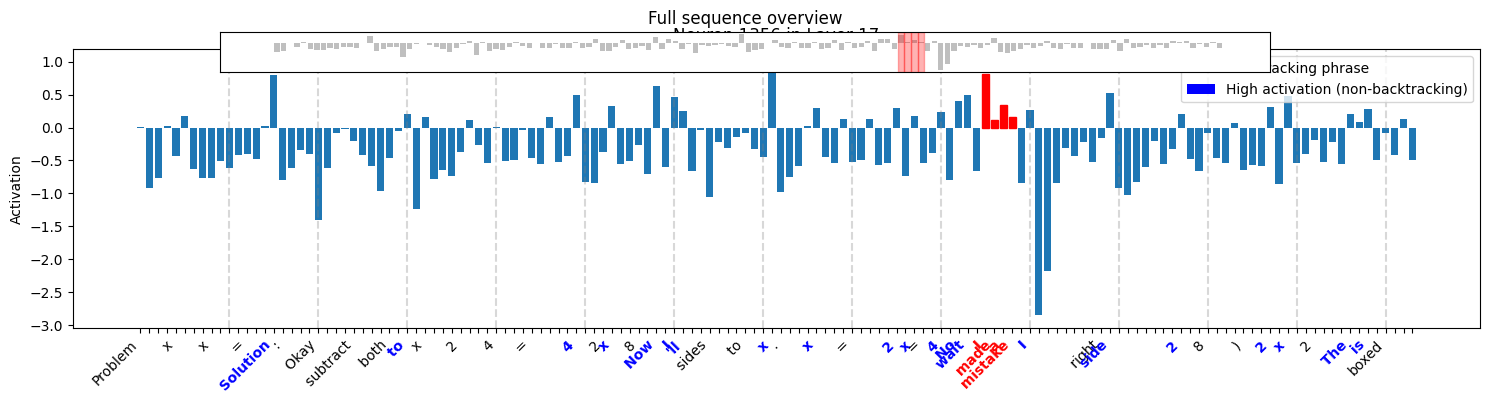

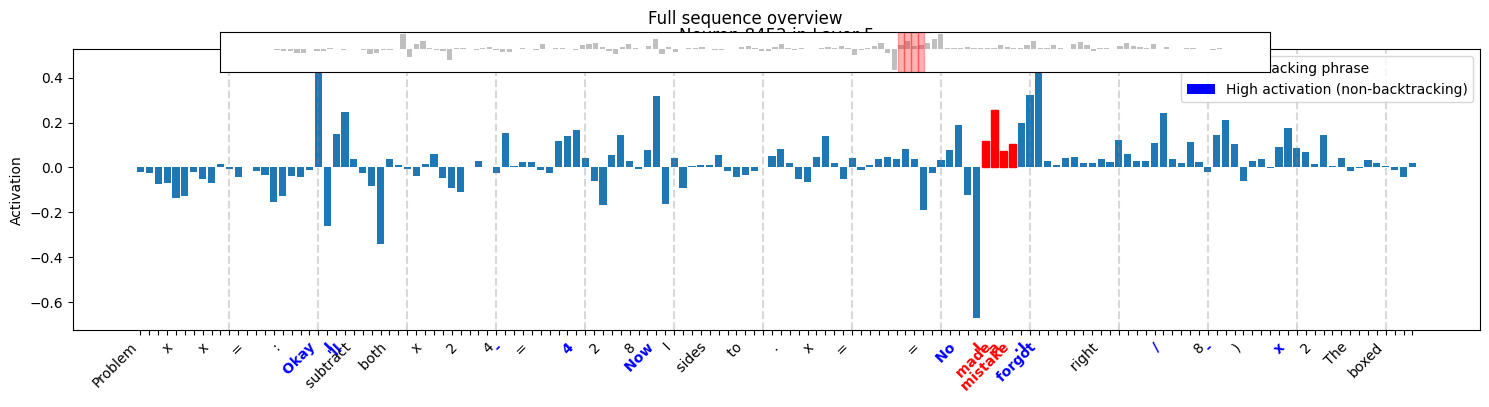

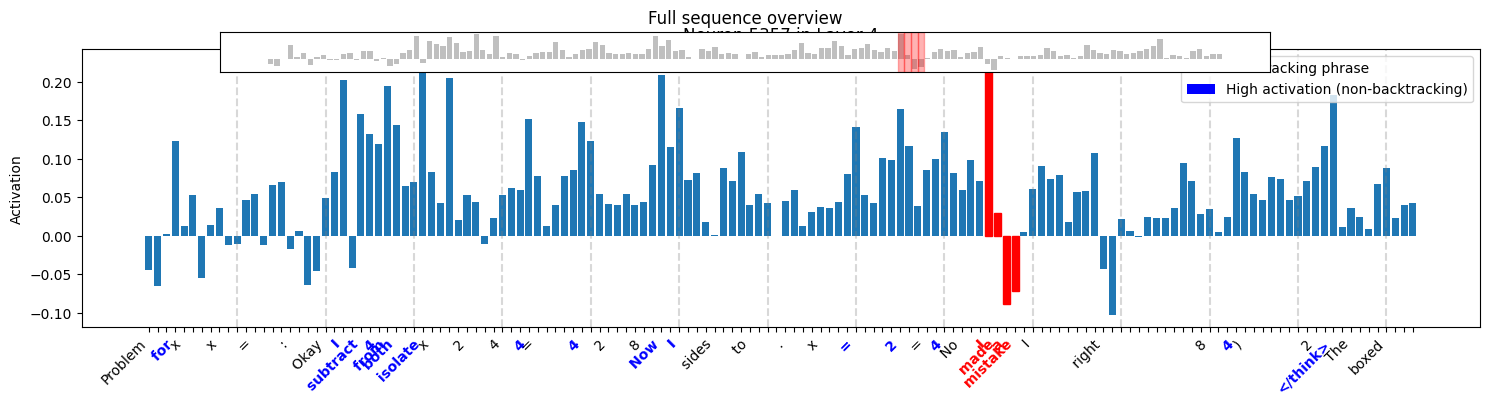

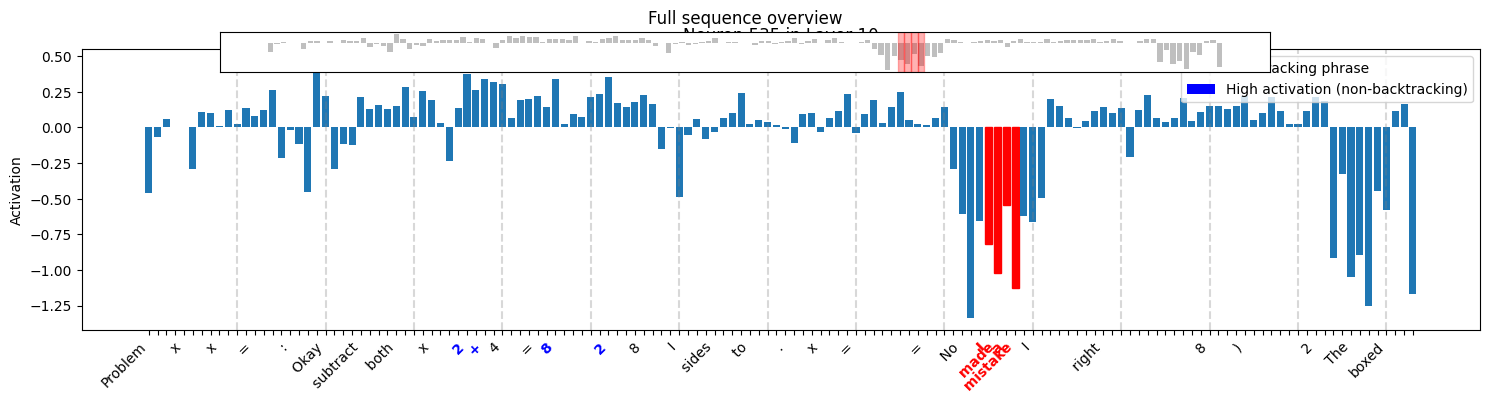

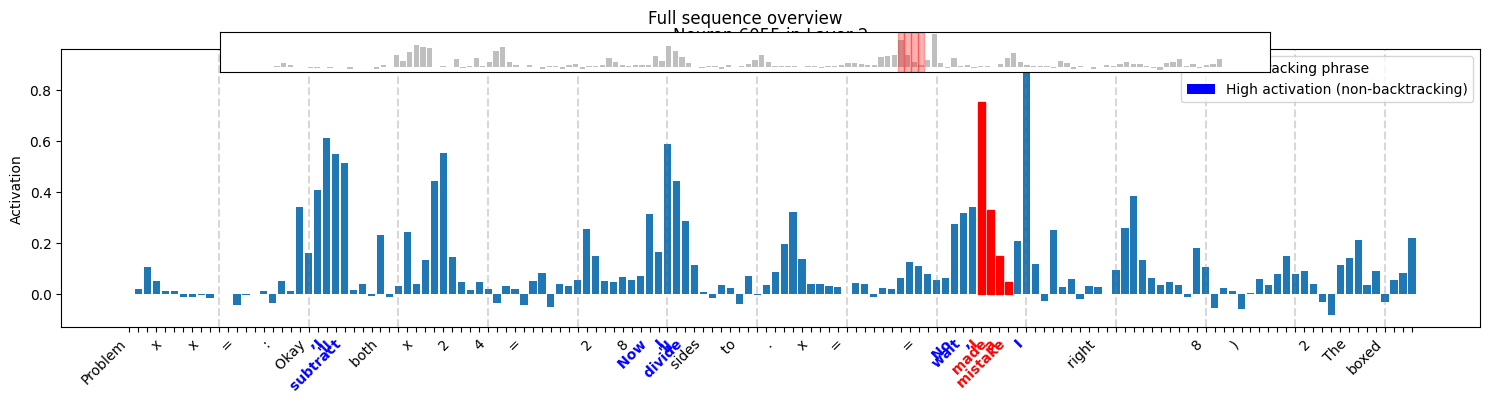

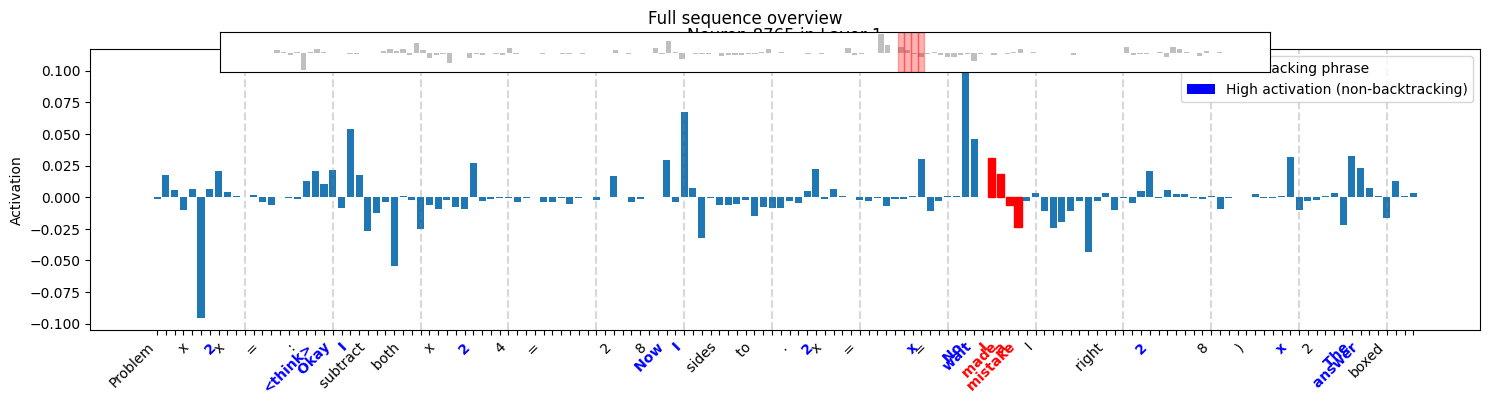

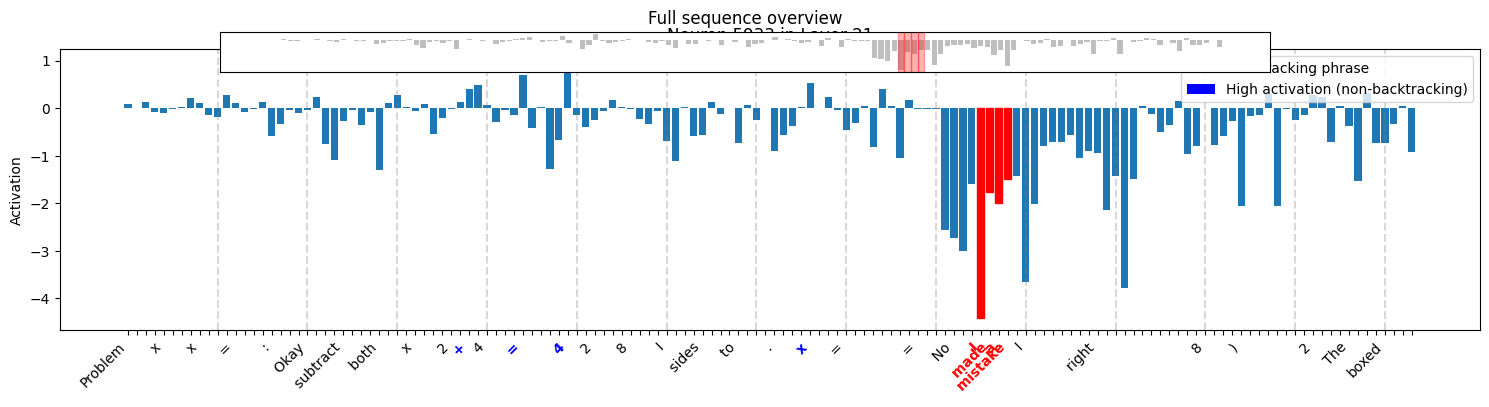

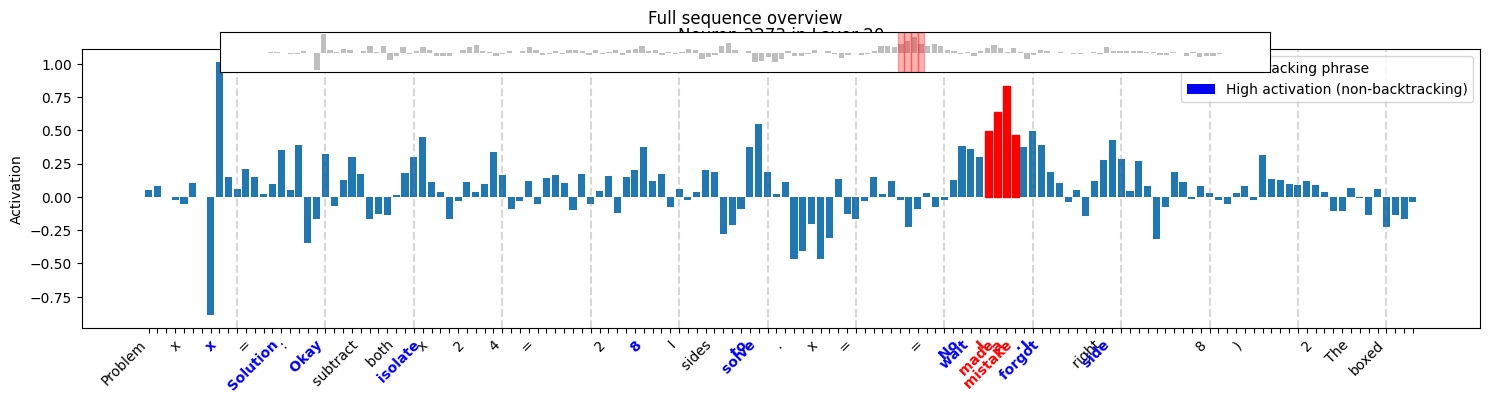

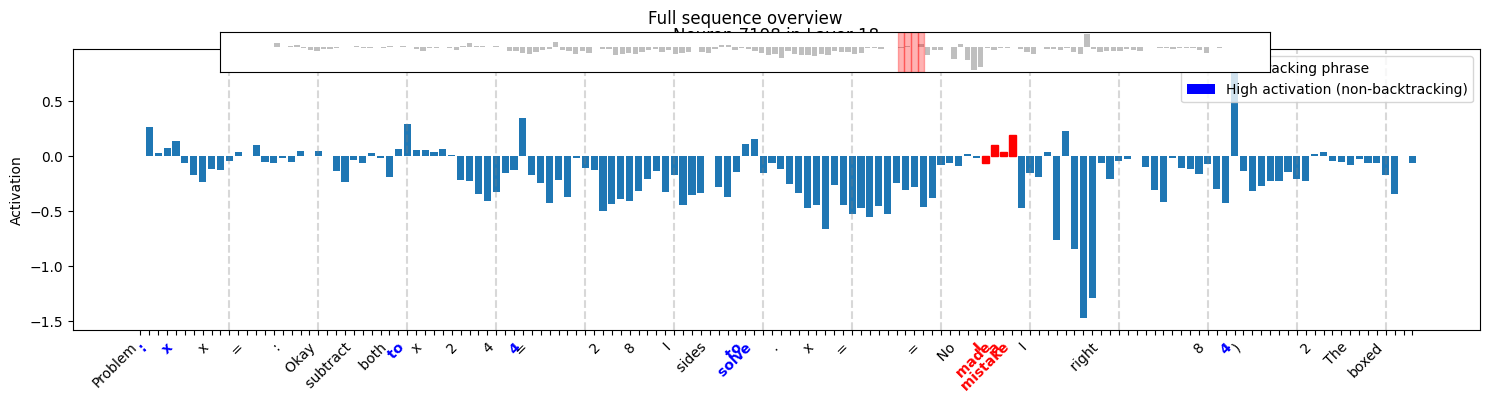

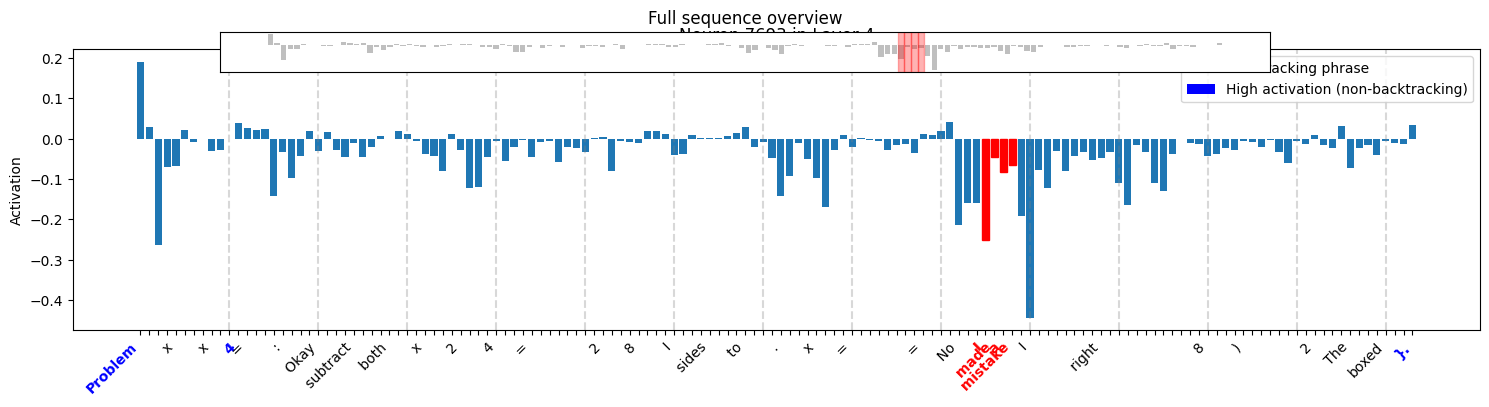

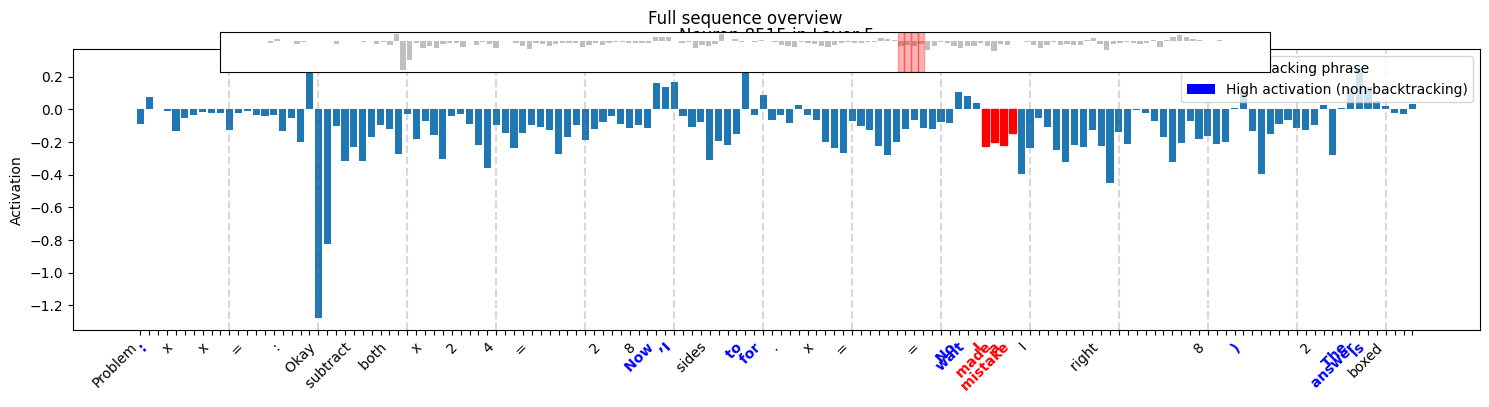

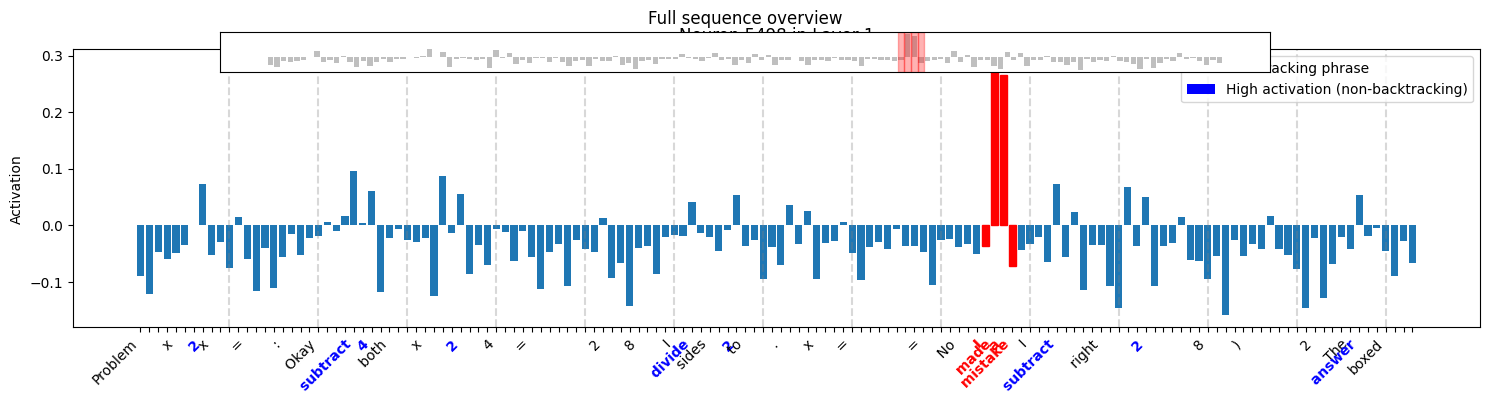

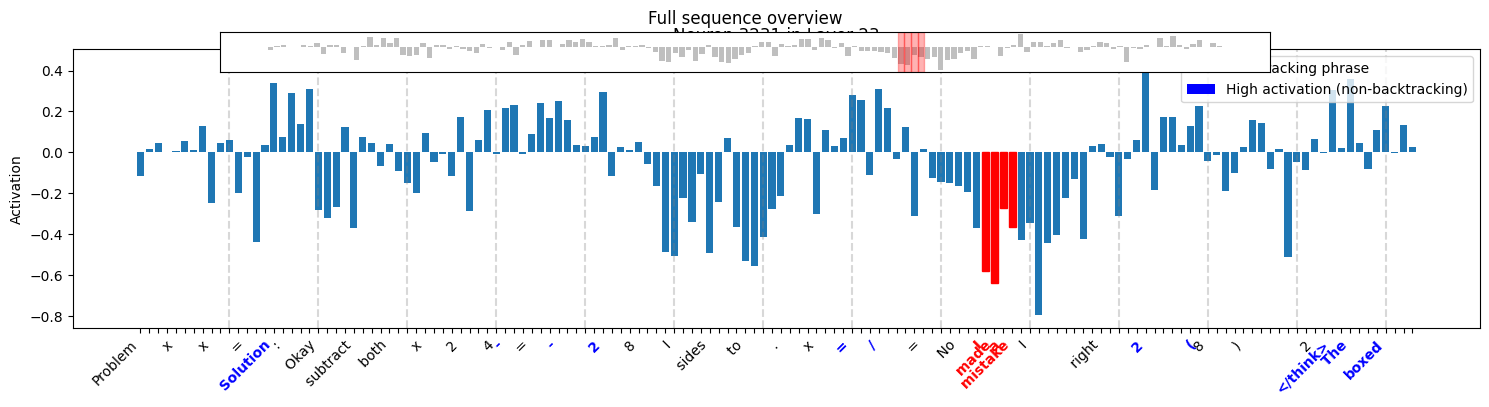

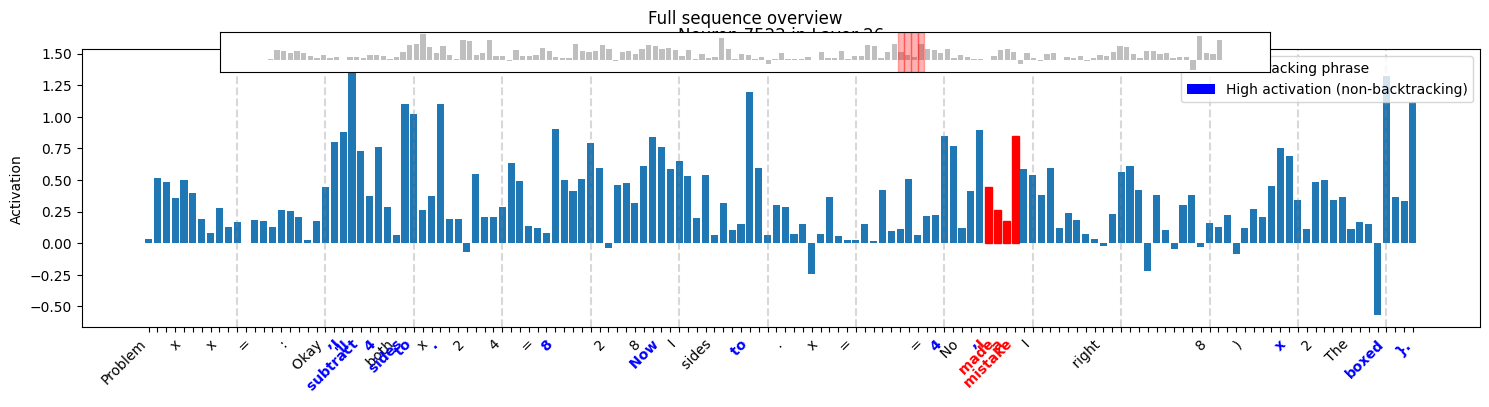

In [37]:
fig = visualize_neuron_activations(
    model=model, 
    neuron_info_list=validation_results['overlap_details'], 
    examples=["Problem: Solve for x in 2x + 4 = 8 Solution: \n<think>\n Okay, I'll subtract 4 from both sides to isolate x. \n 2x + 4 - 4 = 8 - 4 \n 2x = 8 \n Now, I'll divide both sides by 2 to solve for x. \n 2x / 2 = 8 / 2 \n x = 4 \n No wait, I made a mistake. I forgot to subtract 4 from the right side. \n 2x / 2 = (8 - 4) / 2 \n x = 2 </think> \n The answer is \\boxed{2}."]
)

In [10]:
def visualize_attention(model, example_text, window_size=100, layer_id=None, avg_over_heads=False):
    """
    Visualize attention patterns using CircuitsVis.
    
    Args:
        model: The HookedTransformer model
        example_text: A single text example
        window_size: Number of tokens to include in the visualization window
        layer_id: The layer to visualize, if None, visualize all layers
        avg_over_heads: If True, average attention over heads for each layer
        
    Returns:
        CircuitsVis visualization
    """    
    # Get tokens and run model with cache
    tokens = model.to_tokens(example_text)
    str_tokens = model.to_str_tokens(example_text)
    
    # Run with cache to get attention patterns
    _, cache = model.run_with_cache(tokens)
    
    # Determine window for visualization
    start_pos = 0
    end_pos = min(len(str_tokens), start_pos + window_size)
    
    # Get attention patterns for all layers
    attention_patterns = []
    for layer in range(model.cfg.n_layers):
        if layer_id is not None and layer != layer_id: continue
        if avg_over_heads:
            # Average over heads dimension
            avg_attn = cache["pattern", layer][0].mean(dim=0, keepdim=True)
            attention_patterns.append(avg_attn)
        else:
            attention_patterns.append(cache["pattern", layer][0])
    
    # Create CircuitsVis visualization
    window_tokens = str_tokens[start_pos:end_pos]
    window_attention = [attn[:, start_pos:end_pos, start_pos:end_pos] for attn in attention_patterns]
    
    # Create attention head names
    attention_head_names = []
    for layer in range(len(window_attention)):
        if avg_over_heads:
            attention_head_names.append(f"Layer {layer} (avg)")
        else:
            for head in range(window_attention[layer].shape[0]):
                attention_head_names.append(f"L{layer}H{head}")
    
    # Flatten attention for CircuitsVis
    flat_attention = torch.cat([attn for attn in window_attention], dim=0)
    
    # Create CircuitsVis visualization
    vis = cv.attention.attention_patterns(tokens=window_tokens, attention=flat_attention)
    
    return vis

In [11]:
example = """
Solve this math problem step by step. Put your final answer in \\boxed{}. 
Problem: If f(x) = x^2 - 3x + 2 and g(x) = 2x + 1, find (f \\circle g)(x). 
Solution: 
\n<think>\n
The composition (f \\circle g)(x) means f(g(x)), which is obtained by substituting g(x) for x in the function f(x).

\n\nSo, (f \\circle g)(x) = f(g(x)) = f(2x + 1)\n\n

Now, I need to substitute 2x + 1 for x in the function f(x) = x^2 - 3x + 2.

\n\nf(2x + 1) = (2x + 1)^2 - 3(2x + 1) + 2

\n\nLet me expand the first term: (2x + 1)^2 = (2x)^2 + 2(2x)(1) + 1^2 = 4x^2 + 4x + 1

\n\nNow, continuing with the substitution:\nf(2x + 1) = 4x^2 + 4x + 1 - 3(2x + 1) + 2
\n= 4x^2 + 4x + 1 - 6x - 3 + 2
\n= 4x^2 + 4x - 6x + 1 - 3 + 2\n= 4x^2 - 2x + 0\n= 4x^2 - 2x
\n\nActually, I made a mistake in my calculation. Let me recalculate:
\nf(2x + 1) = (2x + 1)^2 - 3(2x + 1) + 2
\n= 4x^2 + 4x + 1 - 6x - 3 + 2
\n= 4x^2 + 4x - 6x - 3 + 2
\n= 4x^2 - 2x - 1

\n\nSo, (f \\circle g)(x) = 4x^2 - 2x - 1
\n</think>

\n\nTo find (f \\circle g)(x), I need to compute f(g(x)), which means substituting g(x) into the function f(x).

\n\nStep 1: Identify the functions.
\nf(x) = x^2 - 3x + 2
\ng(x) = 2x + 1

\n\nStep 2: Calculate (f \\circle g)(x) = f(g(x)).
\n(f \\circle g)(x) = f(2x + 1)
\n= (2x + 1)^2 - 3(2x + 1) + 2

\n\nStep 3: Expand and simplify.
\n(2x + 1)^2 = 4x^2 + 4x + 1
\n-3(2x + 1) = -6x - 3

\n\nCombining terms:
\n(f \\circle g)(x) = 4x^2 + 4x + 1 - 6x - 3 + 2
\n= 4x^2 + 4x - 6x - 3 + 2
\n= 4x^2 - 2x - 1

\n\nTherefore, \\boxed{(f \\circ g)(x) = 4x^2 - 2x - 1}"""

In [12]:
with torch.no_grad():
    attention_vis = visualize_attention(model, example, window_size=1000, layer_id=None, avg_over_heads=True)
    display(attention_vis)

In [ ]:
def ablate_neurons_and_test(model, top_neurons, test_problems, device):
    """
    Ablate (zero out) the identified neurons and test the effect on backtracking.
    
    Args:
        model: The HookedTransformer model
        top_neurons: List of top neurons to ablate
        test_problems: List of test problems
        device: The device to run inference on
        
    Returns:
        Dictionary with ablation results
    """
    # Define a hook function to ablate specific neurons
    def ablation_hook(activations, hook, neurons_to_ablate):
        # neurons_to_ablate is a list of (layer, neuron) tuples
        for layer, neuron in neurons_to_ablate:
            if hook.name == f"blocks.{layer}.hook_post":
                activations[0, :, neuron] = 0.0
        return activations
    
    # Prepare neurons to ablate
    neurons_to_ablate = [(n['layer'], n['neuron']) for n in top_neurons[:20]]  # Ablate top 20
    
    ablation_results = {
        'original': [],
        'ablated': []
    }
    
    for problem in tqdm(test_problems, desc="Testing ablation"):
        problem_text = problem['problem']
        
        # Generate solution without ablation
        original_prompt = f"Solve this math problem step by step. Put your final answer in \\boxed{{}}. Problem: {problem_text} Solution: \n<think>\n"
        original_solution = model.generate(original_prompt, 
                                         temperature=0.4,
                                         max_new_tokens=500,
                                         top_p=0.92)
        
        # Count backtracking instances in original
        original_backtracking = identify_backtracking(original_solution)
        
        # Generate solution with ablation
        ablated_solution = ""
        
        # Set up hooks for ablation
        hooks = []
        for layer in set(layer for layer, _ in neurons_to_ablate):
            hook_name = f"blocks.{layer}.hook_post"
            hook_fn = lambda act, hook=None, neurons=neurons_to_ablate: ablation_hook(act, hook, neurons)
            hooks.append((hook_name, hook_fn))
        
        # Generate with hooks
        with model.hooks(hooks):
            ablated_solution = model.generate(original_prompt, 
                                            temperature=0.4,
                                            max_new_tokens=500,
                                            top_p=0.92)
        
        # Count backtracking instances in ablated
        ablated_backtracking = identify_backtracking_enhanced(ablated_solution)
        
        ablation_results['original'].append({
            'problem': problem_text,
            'solution': original_solution,
            'backtracking_count': len(original_backtracking),
            'backtracking_instances': original_backtracking
        })
        
        ablation_results['ablated'].append({
            'problem': problem_text,
            'solution': ablated_solution,
            'backtracking_count': len(ablated_backtracking),
            'backtracking_instances': ablated_backtracking
        })
    
    # Calculate summary statistics
    original_backtracking_count = sum(r['backtracking_count'] for r in ablation_results['original'])
    ablated_backtracking_count = sum(r['backtracking_count'] for r in ablation_results['ablated'])
    
    ablation_results['summary'] = {
        'original_backtracking_total': original_backtracking_count,
        'ablated_backtracking_total': ablated_backtracking_count,
        'percent_change': ((ablated_backtracking_count - original_backtracking_count) / 
                          max(1, original_backtracking_count)) * 100
    }
    
    return ablation_results